# V_SLOPE projection

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from shapely.geometry import mapping
from shapely.geometry import box
from rasterio.mask import mask
import matplotlib as mpl
from matplotlib.colors import LogNorm, SymLogNorm
import os
import mplstereonet
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

import warnings
warnings.filterwarnings("ignore")

In [2]:
def tiff2arr(tif_fid, mask=None):
    if mask is not None:
        with rasterio.open(tif_fid) as src:
            feature = [mapping(mask)]
            masked_band = mask(src, feature, crop=True, all_touched=True)
            arr = masked_band[0]
            pixel_georeferences = masked_band[1] 
            return arr, pixel_georeferences

    else: 
        with rasterio.open(tif_fid) as src:
            arr = src.read(1)
            return arr

LiCSAR interferograms are provided in geographical coordinates. The line of sight unit vectors are normally given by a flight direction measured clockwise from the north. and the incidence angle is measured from the nadir to the horizontal. The provided vectors show unit vectors measured from the surface towards the satellite (This is a Zenith measurement (?))

In [3]:
fids = {}
fids["E_A_fid"] = "./data/129A_05935_131313/129A_05935_131313.geo.E.tif"
fids["N_A_fid"] = "./data/129A_05935_131313/129A_05935_131313.geo.N.tif"
fids["UP_A_fid"] = "./data/129A_05935_131313/129A_05935_131313.geo.U.tif"

fids["E_D_fid"] = "./data/063D_05860_131313/063D_05860_131313.geo.E.tif"
fids["N_D_fid"] = "./data/063D_05860_131313/063D_05860_131313.geo.N.tif"
fids["UP_D_fid"] = "./data/063D_05860_131313/063D_05860_131313.geo.U.tif"

LOS_comps = {}
for track in ["D", "A"]:
    LOS_comps["E_{}".format(track)] = tiff2arr(fids["E_{}_fid".format(track)])
    LOS_comps["N_{}".format(track)] = tiff2arr(fids["N_{}_fid".format(track)])
    LOS_comps["UP_{}".format(track)] = tiff2arr(fids["UP_{}_fid".format(track)])

for track in ["D", "A"]:
    LOS_comps["E_{}_mask".format(track)] = np.ma.masked_where((LOS_comps["E_{}".format(track)] == 0), 
                                                            LOS_comps["E_{}".format(track)])
    LOS_comps["N_{}_mask".format(track)] = np.ma.masked_where((LOS_comps["N_{}".format(track)] == 0), 
                                                            LOS_comps["N_{}".format(track)])
    LOS_comps["UP_{}_mask".format(track)] = np.ma.masked_where((LOS_comps["UP_{}".format(track)] == 0), 
                                                             LOS_comps["UP_{}".format(track)])

### Find the flight direction and incidence angle based on LiCSAR ENU components

In [4]:
def ENU2angles(E, N, UP):
    """
    Return the flight direction and incidence angles based on the ENU decomposed vectors,
    where the given vector points to the southern hemisphere and has the ground --> satellite
    direction.
    """
    # Mask out zeros from matrix
    E_mask = np.ma.masked_where((E == 0), E)
    N_mask = np.ma.masked_where((N == 0), N)
    UP_mask = np.ma.masked_where((UP == 0), UP)

    ##########################
    LOS_dir = np.rad2deg(np.arctan(N_mask/E_mask))
    if np.mean(LOS_dir)<0:
        flight_dir = abs(LOS_dir)+180
        incidence_angle = np.rad2deg(np.arccos(UP_mask))
        return flight_dir, incidence_angle
    else:
        flight_dir = -LOS_dir+360
        incidence_angle = np.rad2deg(np.arccos(UP_mask))
        return flight_dir, incidence_angle

    
    
flight_dir_A, incidence_angle_A = ENU2angles(LOS_comps["E_A"], LOS_comps["N_A"], LOS_comps["UP_A"])
LOS_dir_A = flight_dir_A+-270
mean_flight_dir_A = np.mean(flight_dir_A)
mean_incidence_angle_A = np.mean(incidence_angle_A)

flight_dir_D, incidence_angle_D = ENU2angles(LOS_comps["E_D"], LOS_comps["N_D"], LOS_comps["UP_D"])
LOS_dir_D = flight_dir_D+-270
mean_flight_dir_D = np.mean(flight_dir_D)
mean_incidence_angle_D = np.mean(incidence_angle_D)

print(mean_flight_dir_A, mean_incidence_angle_A)
print(mean_flight_dir_D, mean_incidence_angle_D)

349.69448249300893 39.07939516736717
190.2585326433778 39.328123858619584


In [5]:
def norm_3com(N,E,U):
    #Get the norm of a vector with its components
    return np.sqrt((E)**2+(N)**2+(U)**2)

## Decomposition based on handweger et al 2019
## uses no further rotations or flips and coincides with LiCSBAS product 

# calc_N, calc_E, calc_UP = [np.sin(np.deg2rad(mean_flight_dir_A))*np.sin(np.deg2rad(mean_incidence_angle_A)),
# -np.cos(np.deg2rad(mean_flight_dir_A))*np.sin(np.deg2rad(mean_incidence_angle_A)),
# np.cos(np.deg2rad(mean_incidence_angle_A))]
# print([calc_N,calc_E,calc_UP])
# norm_3com(calc_N,calc_E,calc_UP)


In [6]:
# fig, ax = plt.subplots(2,3, figsize=(16,10))
# ax=ax.ravel()
# im = ax[0].imshow(E_mask, cmap="seismic", vmin=-1,vmax=1)
# ax[0].set_title("E component", size=14)
# im = ax[1].imshow(N_mask, cmap="seismic", vmin=-1,vmax=1)
# ax[1].set_title("N component", size=14)
# im = ax[2].imshow(UP_mask, cmap="seismic", vmin=-1,vmax=1)
# ax[2].set_title("UP component", size=14)

# cax = fig.add_axes([0.91, 0.545, 0.03, 0.32])
# cmap = mpl.cm.seismic
# norm = mpl.colors.Normalize(vmin=-1, vmax=1)
# cbar = mpl.colorbar.ColorbarBase(ax=cax, cmap=cmap, norm=norm, orientation='vertical')
# cbar.set_label('component magnitude', size=14)
# cbar.ax.tick_params(labelsize=14, width=2, length=6) 

# im = ax[3].imshow(LOS_dir, cmap="hsv", vmin=0,vmax=360)
# ax[3].set_title("LOS_dir [from N]", size=14)
# im = ax[4].imshow(incidence_angle, cmap="hsv", vmin=0,vmax=360)
# ax[4].set_title("incidence_angle [From Nadir]", size=14)
# im = ax[5].imshow(flight_dir, cmap="hsv", vmin=0,vmax=360)
# ax[5].set_title("Flight_dir [from N]", size=14)

# cax = fig.add_axes([0.91, 0.145, 0.03, 0.32])
# cmap = mpl.cm.hsv
# norm = mpl.colors.Normalize(vmin=0, vmax=360)
# cbar = mpl.colorbar.ColorbarBase(ax=cax, cmap=cmap, norm=norm, orientation='vertical')
# cbar.set_label('Angles', size=14)
# cbar.ax.tick_params(labelsize=14, width=2, length=6) 

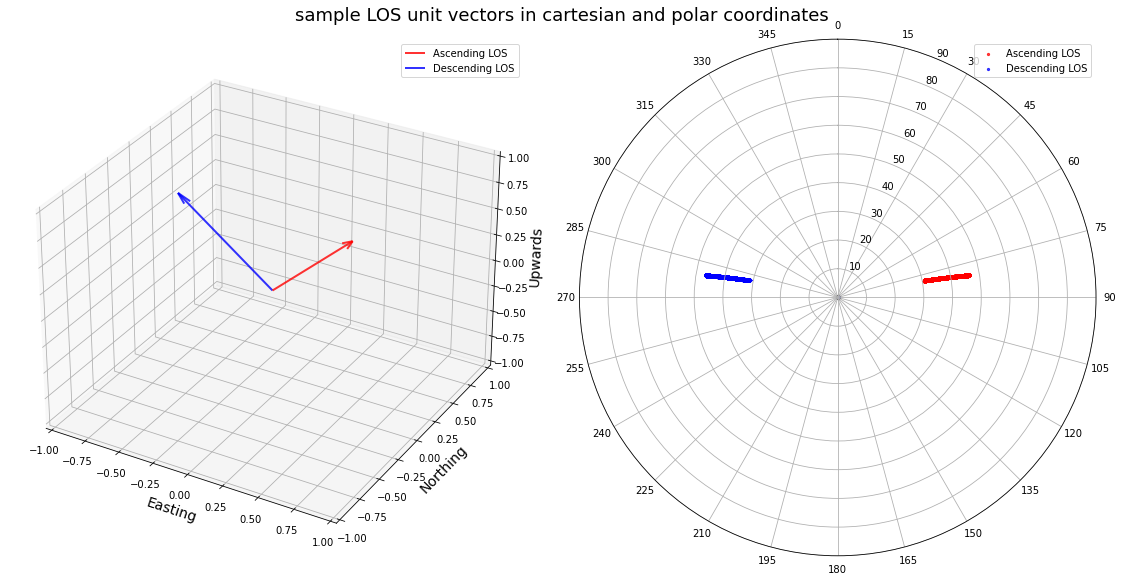

In [7]:
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(121, projection='3d')

ax.quiver(0,0,0,
    LOS_comps["E_D"][1500, 1500],LOS_comps["N_D"][1500, 1500], LOS_comps["UP_D"][1500, 1500], 
    color = 'red', alpha = .8, lw = 2, arrow_length_ratio=0.1, label="Ascending LOS")

ax.quiver(0,0,0,
    LOS_comps["E_A"][1500, 1500],LOS_comps["N_A"][1500, 1500], LOS_comps["UP_D"][1500, 1500], 
    color = 'blue', alpha = .8, lw = 2, arrow_length_ratio=0.1, label="Descending LOS")

ax.set_xlim(-1,1)
ax.set_xlabel("Easting", size=14)
ax.set_ylim(-1,1)
ax.set_ylabel("Northing", size=14)
ax.set_zlim(-1,1)
ax.set_zlabel("Upwards", size=14)
ax.legend()

ax = fig.add_subplot(122, projection='polar')
ax.set_rlim((0,90))
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
ax.set_thetagrids(np.arange(0, 360, 15), labels=np.arange(0, 360, 15))
ax.scatter(np.deg2rad(LOS_dir_A.ravel()[::100]), incidence_angle_A.ravel()[::100], 
           alpha=0.75, s=5, c="red", label="Ascending LOS")
ax.scatter(np.deg2rad(LOS_dir_D.ravel()[::100]), incidence_angle_D.ravel()[::100], 
           alpha=0.75, s=5, c="blue", label="Descending LOS")
ax.legend()

fig.suptitle("sample LOS unit vectors in cartesian and polar coordinates", size=18)
fig.tight_layout()
#In polar plot the inner circle is the vertical and 90 means horizontal look angle

## Toy gausian hill

In order to assess how does the velocity projection performs among the different surface slopes, a toy gaussian hill is created and with its topographic features (slope and aspect using the same reference system as above) the N, E and UP components are produced do the velocity projection along the downslope direction.

In [8]:
def gaussian_hill_elevation(n, b = 2.5):
    x, y = np.meshgrid(np.linspace(-b,b,n),
                        np.linspace(-b,b,n))

    z = np.exp(-x*x-y*y)
    return (x, y, z)

n_step = 211
x, y, z = gaussian_hill_elevation(n_step, b=2.5)
z=z*40

dx,dy = np.gradient(z)
slope_DEM = np.rad2deg(np.arctan(np.sqrt((dx**2) + (dy**2))))
aspect_DEM = np.rad2deg(np.arctan2(dy, -dx))+180

# x, y, z = x.ravel(), y.ravel(), z.ravel()
# p = np.c_[x, y, z]
# n = np.c_[2*x*z, 2*y*z, np.ones(x.shape)]
# n /= np.outer(np.sqrt(4*z*z*(x*x+y*y)+1), np.ones(3))

[Text(1, 0, 'N'),
 Text(90, 0, 'E'),
 Text(180, 0, 'S'),
 Text(270, 0, 'W'),
 Text(360, 0, 'N')]

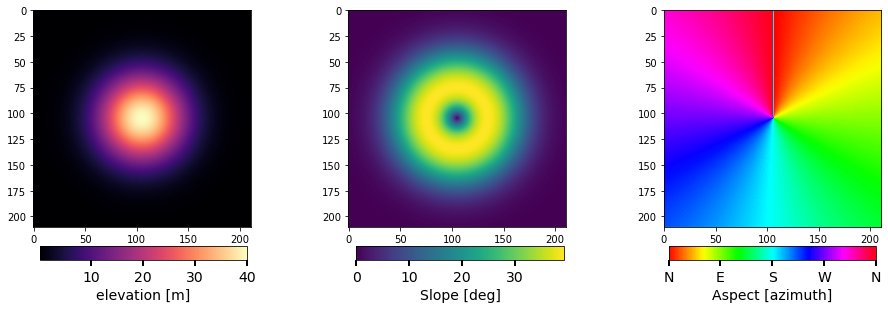

In [9]:
%matplotlib inline
fig, ax = plt.subplots(1,3, figsize=(16,4))
im = ax[0].imshow(z, cmap="magma")
cax = fig.add_axes([0.15, 0.01, 0.18, 0.05])
cmap = mpl.cm.magma
norm = mpl.colors.Normalize(vmin=np.min(z), vmax=np.max(z))
cbar = mpl.colorbar.ColorbarBase(ax=cax, cmap=cmap, norm=norm, orientation='horizontal')
cbar.set_label('elevation [m]', size=14)
cbar.ax.tick_params(labelsize=14, width=2, length=6) 

im = ax[1].imshow(slope_DEM, cmap="viridis")
cax = fig.add_axes([0.425, 0.01, 0.18, 0.05])
cmap = mpl.cm.viridis
norm = mpl.colors.Normalize(vmin=np.min(slope_DEM), vmax=np.max(slope_DEM))
cbar = mpl.colorbar.ColorbarBase(ax=cax, cmap=cmap, norm=norm, orientation='horizontal')
cbar.set_label('Slope [deg]', size=14)
cbar.ax.tick_params(labelsize=14, width=2, length=6) 

im = ax[2].imshow(aspect_DEM, cmap="hsv")
cax = fig.add_axes([0.696, 0.01, 0.18, 0.05])
ang = [1,90,180,270,360]
cmap = mpl.cm.hsv
norm = mpl.colors.Normalize(vmin=np.min(aspect_DEM), vmax=np.max(aspect_DEM))
cbar = mpl.colorbar.ColorbarBase(ax=cax, cmap=cmap, norm=norm, orientation='horizontal', ticks=ang)
cbar.set_label('Aspect [azimuth]', size=14)
cbar.ax.tick_params(labelsize=14, width=2, length=6) 
cardinal=["N","E","S","W","N"]
cax.set_xticklabels(cardinal, minor=False)

## V_Slope using handwerger decomposition (modified) ***

The decomposition of the slope with these definitions end up with vectors that look upwards. all of these are normals to the slope

In [10]:
#Vectors for handwerger et al
D_N = np.sin(np.deg2rad(mean_incidence_angle_D))*np.sin(np.deg2rad(mean_flight_dir_D))
D_E = -np.sin(np.deg2rad(mean_incidence_angle_D))*np.cos(np.deg2rad(mean_flight_dir_D))
D_U = np.cos(np.deg2rad(mean_incidence_angle_D))

A_N = np.sin(np.deg2rad(mean_incidence_angle_A))*np.sin(np.deg2rad(mean_flight_dir_A))
A_E = -np.sin(np.deg2rad(mean_incidence_angle_A))*np.cos(np.deg2rad(mean_flight_dir_A))
A_U = np.cos(np.deg2rad(mean_incidence_angle_A))

print((D_N, D_E, D_U))
print((A_N, A_E, A_U))

# Downslope vector
slope_N = np.sin(np.deg2rad(aspect_DEM+90))*np.sin(np.deg2rad(90-slope_DEM))
slope_E = -np.cos(np.deg2rad(aspect_DEM+90))*np.sin(np.deg2rad(90-slope_DEM))
slope_U = -np.cos(np.deg2rad(90-slope_DEM))

# Normal to the surface (Handwerger)
N_slope_N = np.sin(np.deg2rad(aspect_DEM+90))*np.cos(np.deg2rad(90-slope_DEM))
N_slope_E = -np.cos(np.deg2rad(aspect_DEM+90))*np.cos(np.deg2rad(90-slope_DEM))
N_slope_U = np.cos(np.deg2rad(slope_DEM))

# Upslope vector
upslope_N = -np.cos(np.deg2rad(aspect_DEM))*np.cos(np.deg2rad(slope_DEM))
upslope_E = -np.sin(np.deg2rad(aspect_DEM))*np.cos(np.deg2rad(slope_DEM))
upslope_U = np.sin(np.deg2rad(slope_DEM))

(-0.11286648890034967, 0.6236294596948694, 0.7735292190240731)
(-0.11277605090592431, -0.6202270072182271, 0.7762731618825848)


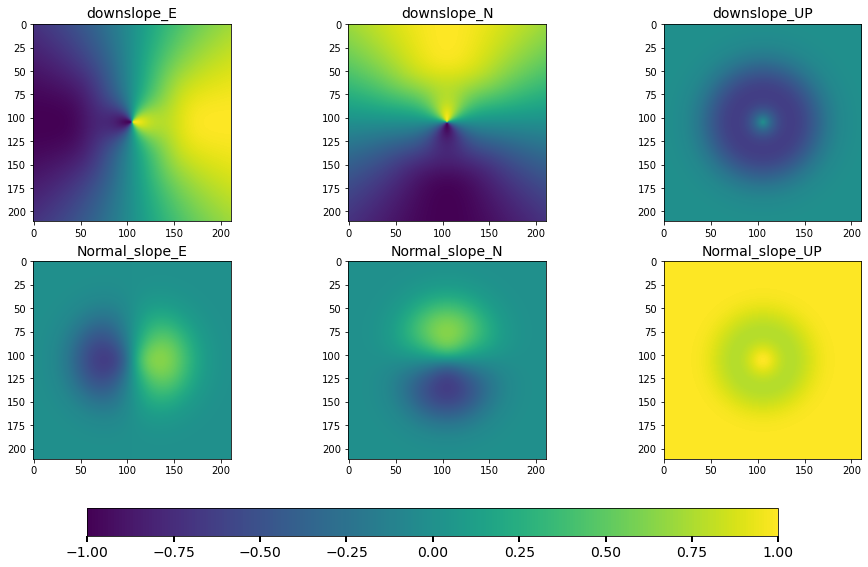

In [11]:
fig, ax = plt.subplots(2,3, figsize=(16,8))
ax=ax.ravel()
im = ax[0].imshow(slope_E, cmap="viridis", vmin=-1, vmax=1)
ax[0].set_title('downslope_E', size=14)

im = ax[1].imshow(slope_N, cmap="viridis", vmin=-1, vmax=1)
ax[1].set_title('downslope_N', size=14)

im = ax[2].imshow(slope_U, cmap="viridis", vmin=-1, vmax=1)
ax[2].set_title('downslope_UP', size=14)

im = ax[3].imshow(N_slope_E, cmap="viridis", vmin=-1, vmax=1)
ax[3].set_title('Normal_slope_E', size=14)

im = ax[4].imshow(N_slope_N, cmap="viridis", vmin=-1, vmax=1)
ax[4].set_title('Normal_slope_N', size=14)

im = ax[5].imshow(N_slope_U, cmap="viridis", vmin=-1, vmax=1)
ax[5].set_title('Normal_slope_UP', size=14)

cax = fig.add_axes([0.2, -0.01, 0.6, 0.05])
norm = mpl.colors.Normalize(vmin=-1, vmax=1)
cmap = mpl.cm.viridis
cbar = mpl.colorbar.ColorbarBase(ax=cax, cmap=cmap, norm=norm, orientation='horizontal')
cbar.ax.tick_params(labelsize=14, width=2, length=6) 

Text(0.5, 0, 'Upwards')

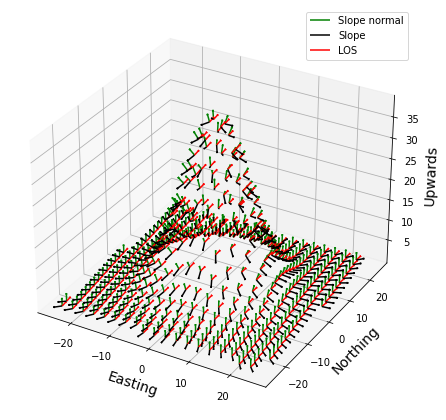

In [12]:
%matplotlib inline
# %matplotlib notebook

fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(121, projection='3d')
step = 100
ax.quiver(x.ravel()[::step]*(np.max(z)/4), -y.ravel()[::step]*(np.max(z)/4), z.ravel()[::step], 
          N_slope_E.ravel()[::step], N_slope_N.ravel()[::step], N_slope_U.ravel()[::step], 
          length=2, normalize=True, arrow_length_ratio=0.2, color="green", label="Slope normal")

ax.quiver(x.ravel()[::step]*(np.max(z)/4), -y.ravel()[::step]*(np.max(z)/4), z.ravel()[::step], 
          slope_E.ravel()[::step], slope_N.ravel()[::step], slope_U.ravel()[::step], 
          length=2, normalize=True, arrow_length_ratio=0.2, color="black", label="Slope")

ax.quiver(x.ravel()[::step]*(np.max(z)/4), -y.ravel()[::step]*(np.max(z)/4), z.ravel()[::step], 
          D_E,D_N, D_U, 
          length=2, normalize=True, arrow_length_ratio=0.2, color="red", label="LOS")

# ax.quiver(p[:,0][::step],p[:,1][::step],p[:,2][::step], 
#           p[:,0][::step]+n[:,0][::step], p[:,1][::step]+n[:,1][::step], p[:,2][::step]+n[:,2][::step], 
#           length=1, normalize=True, arrow_length_ratio=0.2)
ax.legend()
ax.set_xlabel("Easting", size=14)
ax.set_ylabel("Northing", size=14)
ax.set_zlabel("Upwards", size=14)

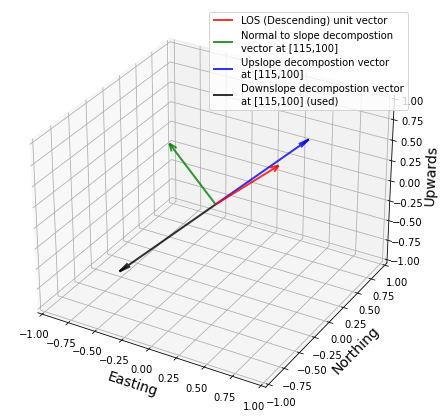

In [13]:
%matplotlib inline
# %matplotlib notebook

fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(121, projection='3d')

ax.quiver(0,0,0,
    D_E,D_N, D_U, 
    color = 'red', alpha = .8, lw = 2, arrow_length_ratio=0.1, label="LOS (Descending) unit vector")

px = 115
py = 100
ax.quiver(0,0,0,
    N_slope_E[px,py],N_slope_N[px,py],N_slope_U[px,py],
    color = 'green', alpha = .8, lw = 2, arrow_length_ratio=0.1, 
          label="Normal to slope decompostion \nvector at [{},{}]".format(px,py))

ax.quiver(0,0,0,
    upslope_E[px,py],upslope_N[px,py],upslope_U[px,py],
    color = 'blue', alpha = .8, lw = 2, arrow_length_ratio=0.1, 
          label="Upslope decompostion vector\nat [{},{}]".format(px,py))

ax.quiver(0,0,0,
    slope_E[px,py],slope_N[px,py],slope_U[px,py],
    color = 'black', alpha = .8, lw = 2, arrow_length_ratio=0.1, 
          label="Downslope decompostion vector\nat [{},{}] (used)".format(px,py))

ax.set_xlim(-1,1)
ax.set_xlabel("Easting", size=14)
ax.set_ylim(-1,1)
ax.set_ylabel("Northing", size=14)
ax.set_zlim(-1,1)
ax.set_zlabel("Upwards", size=14)
ax.legend()

In [14]:
threshold = 0.3

C_up = D_N*upslope_N + D_E*upslope_E + D_U*upslope_U
C_down = D_N*slope_N + D_E*slope_E + D_U*slope_U
C_mask = np.ma.masked_where((C_down > -threshold) & (C_down < threshold), C_down)

#Consider locking C values to 0.3 or -0.3
C_mod = np.where((C_down<0.3) & (C_down>=0), 0.3, C_down)
C_mod = np.where((C_down>-0.3) & (C_down<0), -0.3, C_mod)

# define constant LOS vel
V_LOS = 10 #mm/year
#Calculate C
V_slope = V_LOS/C_mod
# V_mask = np.ma.masked_where((C > -threshold) & (C < threshold) | (slope_DEM < 5), V_slope)
V_mask = np.ma.masked_where((slope_DEM < 5), V_slope)

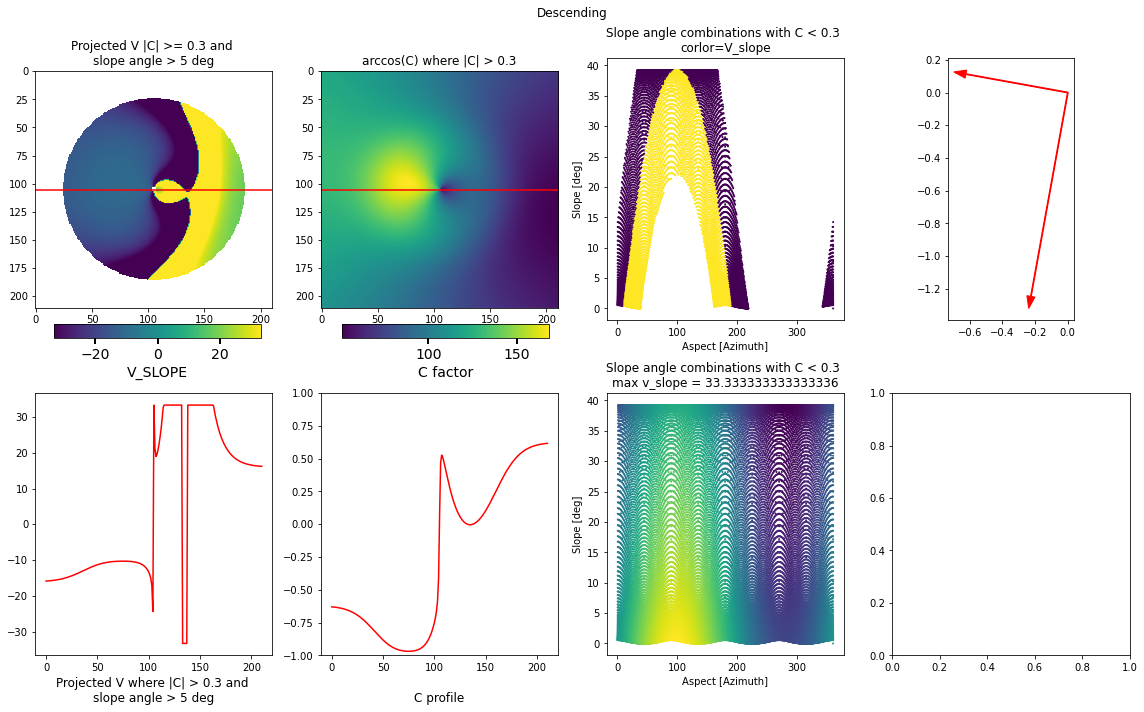

In [15]:
%matplotlib inline

fig, ax = plt.subplots(2,4, figsize=(16,10))
ax=ax.ravel()
im = ax[0].imshow(V_mask)
cax = fig.add_axes([0.05, 0.52, 0.18, 0.02])
cmap = mpl.cm.viridis
norm = mpl.colors.Normalize(vmin=np.nanmin(V_mask), vmax=np.nanmax(V_mask))
cbar = mpl.colorbar.ColorbarBase(ax=cax, cmap=cmap, norm=norm, orientation='horizontal')
cbar.set_label('V_SLOPE', size=14)
cbar.ax.tick_params(labelsize=14, width=2, length=6) 
ax[0].set_title("Projected V |C| >= {} and \nslope angle > 5 deg".format(threshold))
ax[0].plot((0,210),(106,106), c="r")

ax[1].imshow(np.rad2deg(np.arccos(C_down)))
ax[1].plot((0,210),(106,106), c="r")
cax = fig.add_axes([0.3, 0.52, 0.18, 0.02])
norm = mpl.colors.Normalize(vmin=np.nanmin(np.rad2deg(np.arccos(C_down))), 
                            vmax=np.nanmax(np.rad2deg(np.arccos(C_down))))
ax[1].set_title("arccos(C) where |C| > {}".format(threshold))

cbar = mpl.colorbar.ColorbarBase(ax=cax, cmap=cmap, norm=norm, orientation='horizontal')
cbar.set_label('C factor', size=14)
cbar.ax.tick_params(labelsize=14, width=2, length=6) 

im = ax[2].scatter(aspect_DEM[(C_down > -threshold) & (C_down < threshold)], 
                   slope_DEM[(C_down > -threshold) & (C_down < threshold)], 
                   s=1, c=V_slope[(C_down > -threshold) & (C_down < threshold)])
ax[2].set_title("Slope angle combinations with C < {} \ncorlor=V_slope".format(threshold, np.max(V_slope)))
ax[2].set_xlabel("Aspect [Azimuth]")
ax[2].set_ylabel("Slope [deg]")

ax[3].arrow(0,0, 2*D_N, -2*D_E, 
            width=0.005, head_width=0.05, facecolor="r", edgecolor="r")
ax[3].arrow(0,0, -D_E, -D_N, 
            width=0.005, head_width=0.05, facecolor="r", edgecolor="r")
ax[3].set_aspect('equal', 'box')

im = ax[4].plot(V_slope[106,:],color="r")
ax[4].set_title("Projected V where |C| > {} and \nslope angle > 5 deg".format(threshold), y=-0.2)

ax[5].plot(C_down[106,:],color="r")
ax[5].set_ylim(-1,1)
ax[5].set_title("C profile".format(threshold), y=-0.2)


im = ax[6].scatter(aspect_DEM, slope_DEM, s=1, c=C_down)
ax[6].set_title("Slope angle combinations with C < {} \nmax v_slope = {}".format(threshold, np.max(V_slope)))
ax[6].set_xlabel("Aspect [Azimuth]")
ax[6].set_ylabel("Slope [deg]")

# ax[7].arrow(0,0, 2*D_N, -2*D_E, 
#             width=0.005, head_width=0.05, facecolor="r", edgecolor="r")
# ax[7].arrow(0,0, -D_E, -D_N, 
#             width=0.005, head_width=0.05, facecolor="r", edgecolor="r")
# ax[7].set_aspect('equal', 'box')
plt.suptitle("Descending")
plt.tight_layout()

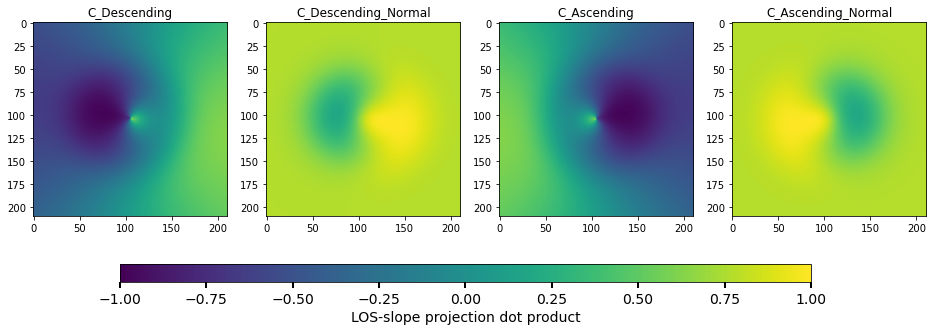

In [29]:
C = {}
C["C_Descending"] = D_N*slope_N + D_E*slope_E + D_U*slope_U
C["C_Descending_Normal"] = D_N*N_slope_N + D_E*N_slope_E + D_U*N_slope_U
C["C_Ascending"] = A_N*slope_N + A_E*slope_E + A_U*slope_U
C["C_Ascending_Normal"] = A_N*N_slope_N + A_E*N_slope_E + A_U*N_slope_U

i = 0
fig, ax = plt.subplots(1,4, figsize=(16,5))
for key, value in C.items():
    im = ax[i].imshow(value, vmin=-1, vmax=1)
    ax[i].set_title(key)
    i+=1

cax = fig.add_axes([0.2, 0.05, 0.6, 0.05])
norm = mpl.colors.Normalize(vmin=-1, vmax=1)
cmap = mpl.cm.viridis
cbar = mpl.colorbar.ColorbarBase(ax=cax, cmap=cmap, norm=norm, orientation='horizontal')
cbar.ax.tick_params(labelsize=14, width=2, length=6) 
cbar.set_label('LOS-slope projection dot product', size=14)


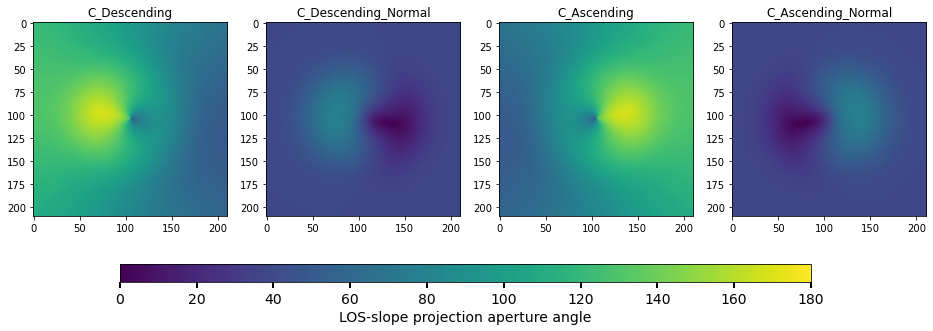

In [30]:
C = {}
C["C_Descending"] = D_N*slope_N + D_E*slope_E + D_U*slope_U
C["C_Descending_Normal"] = D_N*N_slope_N + D_E*N_slope_E + D_U*N_slope_U
C["C_Ascending"] = A_N*slope_N + A_E*slope_E + A_U*slope_U
C["C_Ascending_Normal"] = A_N*N_slope_N + A_E*N_slope_E + A_U*N_slope_U

i = 0
fig, ax = plt.subplots(1,4, figsize=(16,5))
for key, value in C.items():
    im = ax[i].imshow(np.rad2deg(np.arccos(value)), vmin=np.rad2deg(np.arccos(1)), vmax=np.rad2deg(np.arccos(-1)))
    ax[i].set_title(key)
    i+=1

cax = fig.add_axes([0.2, 0.05, 0.6, 0.05])
norm = mpl.colors.Normalize(vmin=np.rad2deg(np.arccos(1)), vmax=np.rad2deg(np.arccos(-1)))
cmap = mpl.cm.viridis
cbar = mpl.colorbar.ColorbarBase(ax=cax, cmap=cmap, norm=norm, orientation='horizontal')
cbar.ax.tick_params(labelsize=14, width=2, length=6) 
cbar.set_label('LOS-slope projection aperture angle', size=14)


In [18]:
print("cos(beta)")
for key, value in C.items():
    print(key)
    print("min_angle = {}, max_angle = {}".format(np.min(np.rad2deg(np.arccos(value))), 
                                                  np.max(np.rad2deg(np.arccos(value)))))

cos(beta)
C_Descending
min_angle = 51.10785833083363, max_angle = 168.55586324164946
C_Descending_Normal
min_angle = 0.1678860024057971, max_angle = 78.55997863362532
C_Ascending
min_angle = 51.355513102998714, max_angle = 168.30627322081762
C_Ascending_Normal
min_angle = 0.1165760364895402, max_angle = 78.31108617638588


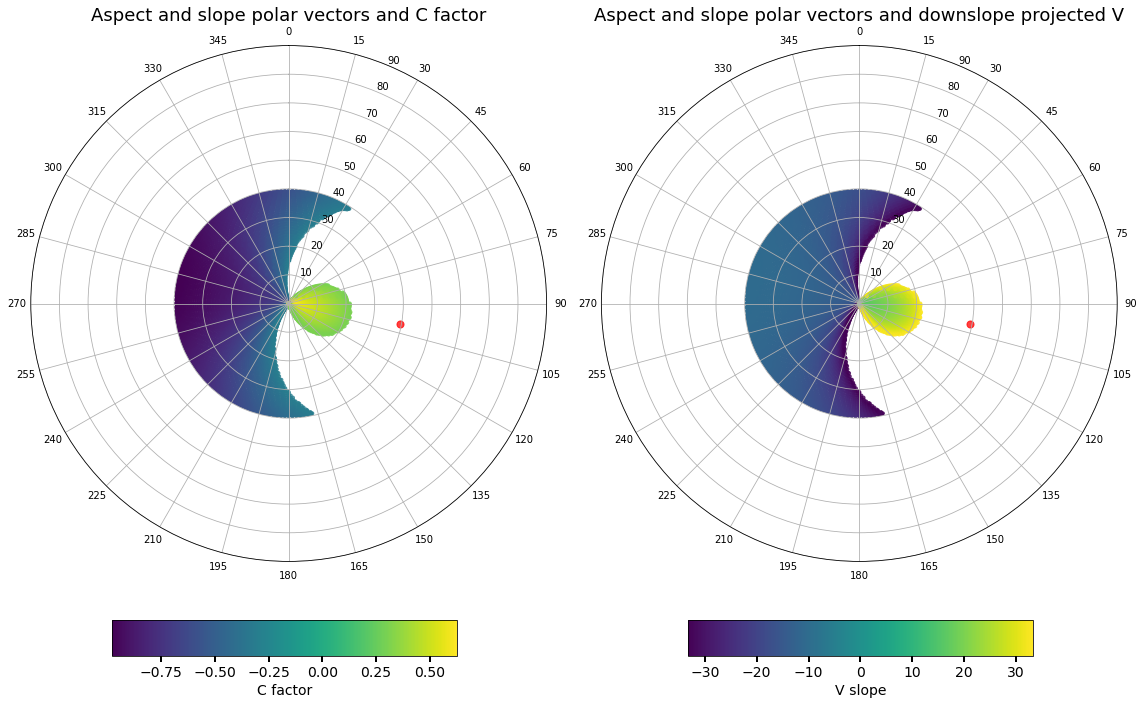

In [19]:
fig = plt.figure(figsize=(16,10))

ax = fig.add_subplot(121, projection='polar')

ax.set_rlim((0,90))
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
ax.set_thetagrids(np.arange(0, 360, 15), labels=np.arange(0, 360, 15))


# ax.scatter(np.deg2rad(aspect_DEM[abs(C)>0.3].ravel()), slope_DEM[abs(C)>0.3].ravel(), c=C[abs(C)>0.3], alpha=0.75, s=10)
ax.scatter(np.deg2rad(aspect_DEM.ravel()), slope_DEM.ravel(), c=C_mask, alpha=0.75, s=10)

#plot LOS unit vector
ax.scatter(np.deg2rad(mean_flight_dir_D-90), mean_incidence_angle_D, alpha=0.75, s=50, color="red")

cax = fig.add_axes([0.1, 0.01, 0.3, 0.05])
cmap = mpl.cm.viridis
norm = mpl.colors.Normalize(vmin=np.min(C_down), vmax=np.max(C_down))
cbar = mpl.colorbar.ColorbarBase(ax=cax, cmap=cmap, norm=norm, orientation='horizontal')
cbar.set_label('C factor', size=14)
cbar.ax.tick_params(labelsize=14, width=2, length=6) 
ax.set_title("Aspect and slope polar vectors and C factor", size=18)


ax = fig.add_subplot(122, projection='polar')
ax.set_rlim((0,90))
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
ax.set_thetagrids(np.arange(0, 360, 15), labels=np.arange(0, 360, 15))
ax.scatter(np.deg2rad(aspect_DEM[abs(C_down)>0.3].ravel()), 
           slope_DEM[abs(C_down)>0.3].ravel(), c=V_slope[abs(C_down)>0.3], alpha=0.75, s=10)

#plot LOS unit vector
ax.scatter(np.deg2rad(mean_flight_dir_D-90), mean_incidence_angle_D, alpha=0.75, s=50, color="red")

cax = fig.add_axes([0.6, 0.01, 0.3, 0.05])
cmap = mpl.cm.viridis
norm = mpl.colors.Normalize(vmin=np.min(V_slope[abs(C_down)>0.3]), vmax=np.max(V_slope[abs(C_down)>0.3]))
cbar = mpl.colorbar.ColorbarBase(ax=cax, cmap=cmap, norm=norm, orientation='horizontal')
cbar.set_label('V slope', size=14)
cbar.ax.tick_params(labelsize=14, width=2, length=6) 


ax.set_title("Aspect and slope polar vectors and downslope projected V", size=18)
fig.tight_layout()

fig.tight_layout()

## R index

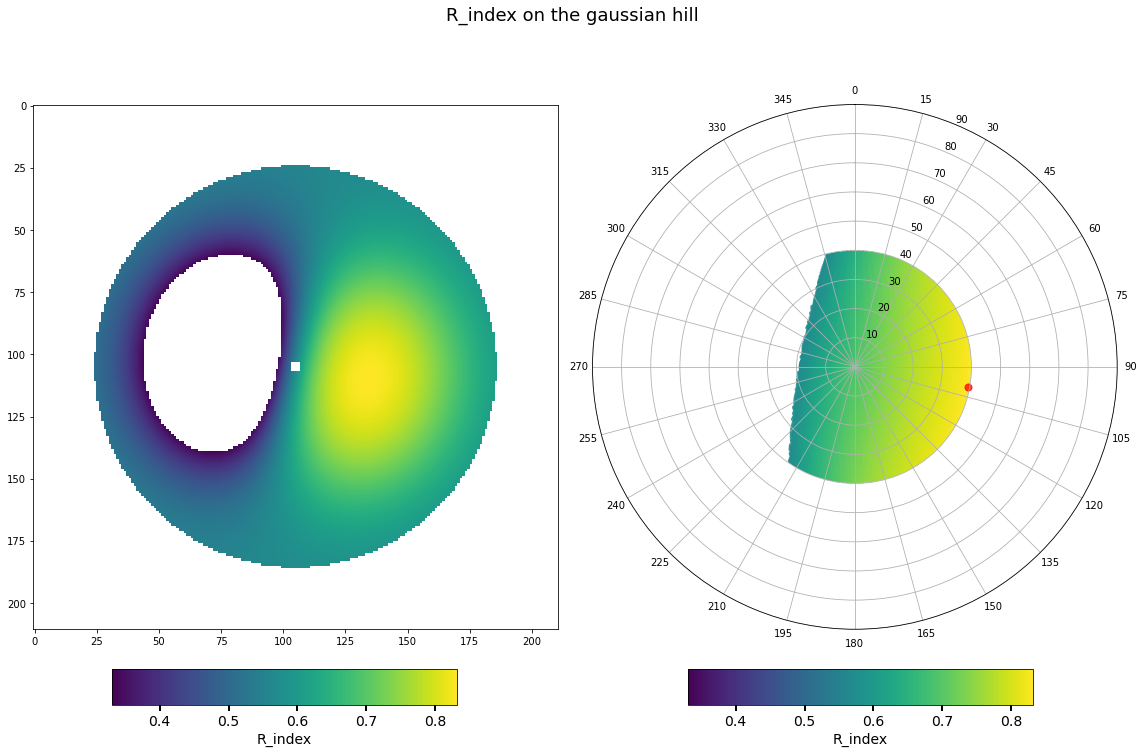

In [20]:
# Notti 2008 describes better this index
# R= R-index,S= slope   derived   from   DEM,Aα= aspect derived from DEM 
# and correct with angle from north of the satellite track (i.e.−8◦for TerraSAR 
# descending +188◦forALOS ascending geometry),θ= incident angle of LOS


# R= −sin(arctan(tanS·sinAα)−θ)

R_index = -np.sin(np.arctan(np.tan(np.deg2rad(slope_DEM))*
                            np.sin(np.deg2rad(aspect_DEM)-np.deg2rad(mean_flight_dir_D)) - 
                            np.deg2rad(mean_incidence_angle_D)))

R_mask = np.ma.masked_where((slope_DEM < 5) | (R_index <0.33), R_index)
R_thresh = 0.33

fig = plt.figure(figsize=(16,10))

# fig, ax = plt.subplots(1,1, figsize=(16,10))

ax = fig.add_subplot(121)
im = ax.imshow(R_mask)

cax = fig.add_axes([0.1, 0.01, 0.3, 0.05])
cmap = mpl.cm.viridis
norm = mpl.colors.Normalize(vmin=np.min(R_mask), vmax=np.max(R_mask))
cbar = mpl.colorbar.ColorbarBase(ax=cax, cmap=cmap, norm=norm, orientation='horizontal')
cbar.set_label('R_index', size=14)
cbar.ax.tick_params(labelsize=14, width=2, length=6) 


ax = fig.add_subplot(122, projection='polar')
ax.set_rlim((0,90))
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
ax.set_thetagrids(np.arange(0, 360, 15), labels=np.arange(0, 360, 15))
ax.scatter(np.deg2rad(aspect_DEM[R_index>R_thresh].ravel()), 
           slope_DEM[R_index>R_thresh].ravel(), 
           c=R_index[R_index>R_thresh], alpha=0.75, s=10,
           vmin=np.min(R_index), vmax=np.max(R_index))
#plot LOS unit vector
ax.scatter(np.deg2rad(mean_flight_dir_D-90), mean_incidence_angle_D, alpha=0.75, s=50, color="red")

cax = fig.add_axes([0.6, 0.01, 0.3, 0.05])
cmap = mpl.cm.viridis
norm = mpl.colors.Normalize(vmin=np.min(R_mask), vmax=np.max(R_mask))
cbar = mpl.colorbar.ColorbarBase(ax=cax, cmap=cmap, norm=norm, orientation='horizontal')
cbar.set_label('R_index', size=14)
cbar.ax.tick_params(labelsize=14, width=2, length=6) 

fig.suptitle("R_index on the gaussian hill", size=18)
fig.tight_layout()

Text(0.5, 1.0, 'downslope projected velocity where R>0.33 and slope > 5deg')

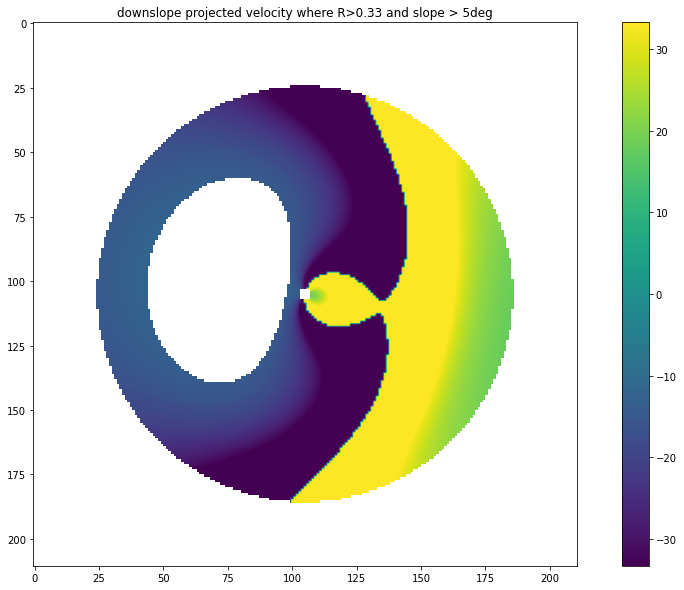

In [21]:
V_mask = np.ma.masked_where((slope_DEM < 5) | (R_index <0.33), V_slope)

fig, ax = plt.subplots(1,1, figsize=(16,10))
im = ax.imshow(V_mask)
cbar =  plt.colorbar(im)
ax.set_title("downslope projected velocity where R>0.33 and slope > 5deg")

In [22]:
# get satellite flight direction and incidence angles from ENU components
def ENU2angles(E, N, UP):
    """
    Return the flight direction and incidence angles based on the ENU decomposed vectors,
    where the given vector points to the southern hemisphere and has the ground --> satellite
    direction.
    """
    # Mask out zeros from matrix
    E_mask = np.ma.masked_where((E == 0), E)
    N_mask = np.ma.masked_where((N == 0), N)
    UP_mask = np.ma.masked_where((UP == 0), UP)

    ##########################
    LOS_dir = np.rad2deg(np.arctan(N_mask/E_mask))
    if np.mean(LOS_dir)<0:
        flight_dir = abs(LOS_dir)+180
        incidence_angle = np.rad2deg(np.arccos(UP_mask))
        return flight_dir, incidence_angle
    else:
        print("Is the ENU vector looking from the ground")
        return
    
def R_index(flight_dir, incidence_angle, slope, aspect):
    R_index = -np.sin(np.arctan(np.tan(np.deg2rad(slope))*
                                np.sin(np.deg2rad(aspect)-np.deg2rad(flight_dir)) - 
                                np.deg2rad(incidence_angle)))
    return R_index

In [23]:
DEM_A_fid = "./data/129A_05935_131313/129A_05935_131313.geo.hgt.tif"
DEM_D_fid = "./data/063D_05860_131313/063D_05860_131313.geo.hgt.tif"

DEM = tiff2arr(DEM_D_fid)
dx,dy = np.gradient(DEM, 100)
slope_DEM = np.rad2deg(np.arctan(np.sqrt((dx**2) + (dy**2))))
aspect_DEM = np.rad2deg(np.arctan2(dy, -dx))+180

In [24]:
r = R_index(flight_dir_D, incidence_angle_D, slope_DEM, aspect_DEM)

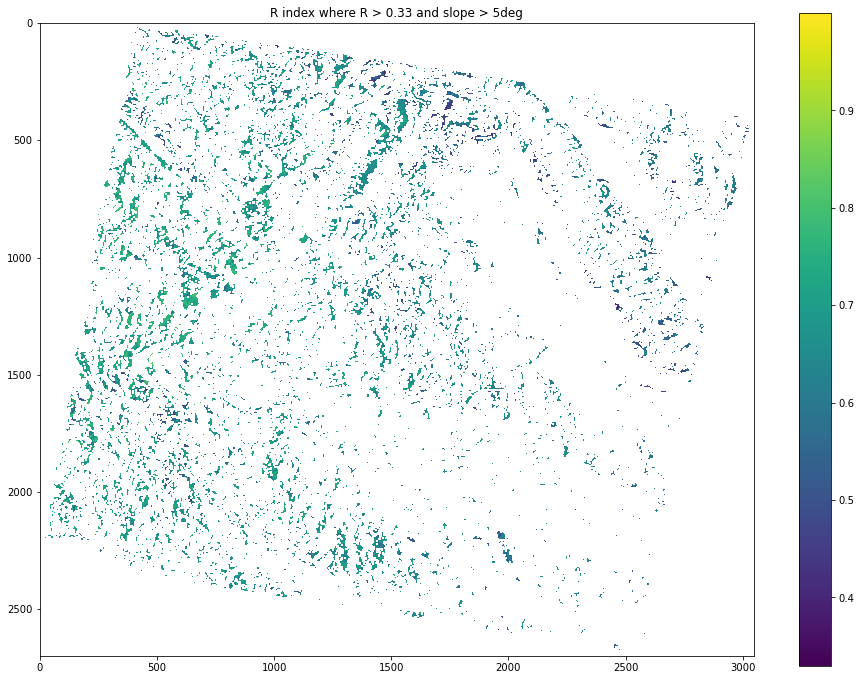

In [25]:
R_mask = np.ma.masked_where((slope_DEM < 5) | (r <0.33), r)


fig, ax = plt.subplots(1,1, figsize=(16,12))
im = ax.imshow(R_mask)
cbar = plt.colorbar(im)
ax.set_title("R index where R > 0.33 and slope > 5deg")
plt.show()

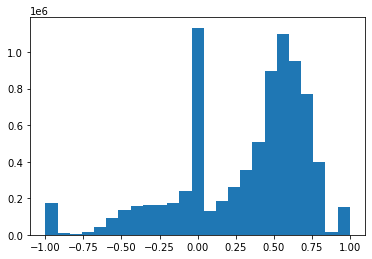

In [26]:
plt.hist(r.ravel(), bins=25)
plt.show()

# Projection of a mogi model

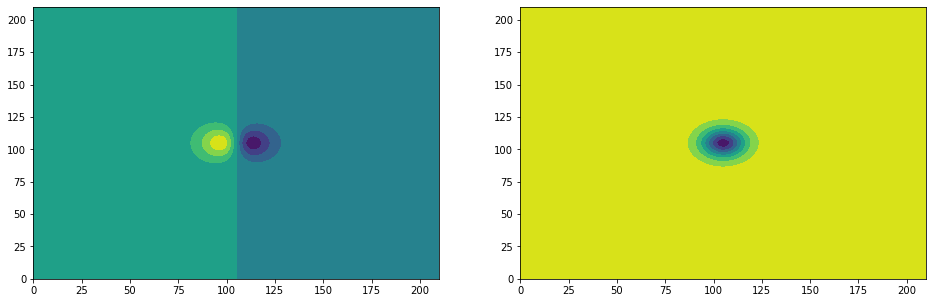

In [27]:
d = 500 #m depth
delta_V = -10000 #m pressure change

def Uv2(b=2500, n=211):
    x, y = np.meshgrid(np.linspace(-b,b,n),
                        np.linspace(-b,b,n))
    r = np.sqrt((x**2)+(y**2))
    
    Uv=(3*delta_V*d)/(4*np.pi*(((d**2)+(r**2))**(3.5)))
    
    return Uv

def Uh2(b=2500, n=211):
    x, y = np.meshgrid(np.linspace(-b,b,n),
                    np.linspace(-b,b,n))
    r = np.sqrt((x**2)+(y**2))
    Uh=(3*delta_V*x)/(4*np.pi*(((d**2)+(r**2))**(3.5)))
    return Uh*1E+16

Uv = Uv2()
Uh = Uh2()

fig, ax = plt.subplots(1,2, figsize=(16,5))
im = ax[0].contourf(Uh)
im = ax[1].contourf(Uv)


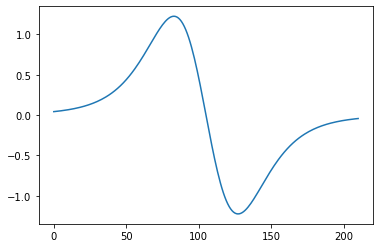

In [28]:
plt.plot(Uh[55,:])